### Question1

* $dr(t)=(\mu-\kappa r(t))dt+\sqrt{\gamma r(t)+\sigma}dW(t)$
* Show that $p(t,T)=e^{A(t,T)-B(t,T)r(t)}$
* Where A & B satisfies the Ricatti equations
$$\frac{dA}{dt}-\mu B+\frac{1}{2}\sigma B^2=0$$
$$\frac{dB}{dt}-\kappa B-\frac{1}{2}\gamma B^2+1=0$$


#### Answer

* $p(t,T)=E[e^{\int_t^T r(s)ds}|r(t)=t]$
* $M(t,T)=e^{-\int_0^t r(s)ds}p(t,T) $  is martingale for $t \in [0,T]$,since it is a tradable asset divided by a numeraire(money account)
* $$dM=e^{-\int_0^t r(s)ds}(-rp+p_t+p_r(\mu-\kappa r(t))+\frac{1}{2}p_{rr}(\gamma r(t)+\sigma))dt+e^{-\int_0^t r(s)ds}p_r\sqrt{\gamma r(t)+\sigma}dW_t$$
* So we get the PDE
\begin{align*} 
-rp+p_r(\mu-\kappa r(t))+ \frac{1}{2}p_{rr}(\gamma r(t)+\sigma)=0\\
p|_{t=T}=1
\end{align*}


* Let $p(t,T)=e^{A(t,T)-B(t,T)r(t)}$
* We get $-rp+(A'-B'r)p-B(\mu-\kappa r)p+\frac{1}{2}B^2(\gamma r+\sigma)p=0$
* Seperate the constant and r term, we have
\begin{align*} 
A'-\mu B+\frac{1}{2}\sigma B^2=0 \\
B'-\kappa B-\frac{1}{2}\gamma B^2+1=0
\end{align*}

In [2]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import minimize

/Users/qichaohuang/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [47]:
data=pd.read_excel("CMT-all.xlsx")
data.set_index('Date',inplace=True)
data=data.loc["2007-01-02":]

In [4]:
data.head()

,1M,3M,6M,1Y,2Y,3Y,5Y,7Y,10Y,20Y,30Y
Date,,,,,,,,,,,
2007-01-02,4.79,5.07,5.11,5.00,4.80,4.71,4.68,4.68,4.68,4.87,4.79
2007-01-03,4.84,5.05,5.09,4.98,4.76,4.69,4.66,4.66,4.67,4.85,4.77
2007-01-04,4.80,5.04,5.07,4.95,4.71,4.63,4.61,4.61,4.62,4.81,4.72
2007-01-05,4.81,5.05,5.09,4.98,4.76,4.68,4.65,4.65,4.65,4.84,4.74
2007-01-08,4.87,5.08,5.13,5.01,4.78,4.70,4.66,4.66,4.66,4.84,4.74


$$y_t(\tau)=\beta_{1t}+\beta_{2t}(\frac{1-e^{-\lambda\tau}}{\lambda\tau})+
\beta_{3t}(\frac{1-e^{-\lambda\tau}}{\lambda\tau}-e^{-\lambda\tau})$$

      fun: 0.09442717575105425
 hess_inv: array([[ 0.33528054, -0.2556308 , -1.00831998],
       [-0.2556308 ,  0.43009897,  0.26846312],
       [-1.00831998,  0.26846312,  5.39191855]])
      jac: array([  1.86264515e-09,  -2.04890966e-08,  -1.86264515e-09])
  message: 'Optimization terminated successfully.'
     nfev: 40
      nit: 5
     njev: 8
   status: 0
  success: True
        x: array([ 4.78098793,  0.28410756, -0.62191594])


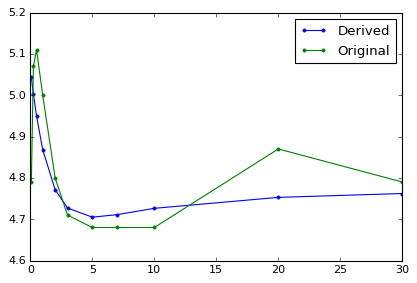

In [5]:
expire_time=np.array([1./12,0.25,0.5,1,2,3,5,7,10,20,30])

def cost_function_beta(beta,expire,yield_rate,Lambda):
    if(np.isnan(yield_rate).any()):
        yield_rate=yield_rate.as_matrix()
        expire_new=np.delete(expire,np.argwhere(np.isnan(yield_rate)))
        yield_rate_new=np.delete(yield_rate,np.argwhere(np.isnan(yield_rate)))
        time_lam=expire_new*Lambda
        cost=np.array([beta[0]+beta[1]*(1-np.exp(-tmp))/tmp+beta[2]*((1-np.exp(-tmp))/tmp-np.exp(-tmp)) for tmp in time_lam])
        return np.sum((cost-yield_rate_new)**2)
        #raise ValueError("Np.nan in index")
    time_lam=expire*Lambda
    cost=np.array([beta[0]+beta[1]*(1-np.exp(-tmp))/tmp+beta[2]*((1-np.exp(-tmp))/tmp-np.exp(-tmp)) for tmp in time_lam])
    return np.sum((cost-yield_rate)**2)
cost_function_beta([0.05,0.1,0.05],expire_time,data.iloc[0],0.06)
func=minimize(cost_function_beta,[2.,1.,1.],method='BFGS',args=(expire_time,data.iloc[1],0.6))
print func
beta=func.x
time_lam=expire_time*0.6
plt.plot(expire_time,np.array([beta[0]+beta[1]*(1-np.exp(-tmp))/tmp+beta[2]*((1-np.exp(-tmp))/tmp-np.exp(-tmp)) for tmp in time_lam]),'.-')
plt.plot(expire_time,data.iloc[0],'.-')
plt.legend(['Derived','Original'])

In [6]:
from scipy.optimize import leastsq

def error_beta(expire,yield_rate,x0,Lambda):
    
    def cost_function_beta_1(beta,expire,yield_rate,Lambda):
        if(np.isnan(yield_rate).any()):
            #print yield_rate.name
            yield_rate=yield_rate.as_matrix()
            expire_new=np.delete(expire,np.argwhere(np.isnan(yield_rate)))
            yield_rate_new=np.delete(yield_rate,np.argwhere(np.isnan(yield_rate)))
            time_lam=expire_new*Lambda
            cost=np.array([beta[0]+beta[1]*(1-np.exp(-tmp))/tmp+beta[2]*((1-np.exp(-tmp))/tmp-np.exp(-tmp)) for tmp in time_lam])
            return cost-yield_rate_new
        time_lam=expire*Lambda
        cost=np.array([beta[0]+beta[1]*(1-np.exp(-tmp))/tmp+beta[2]*((1-np.exp(-tmp))/tmp-np.exp(-tmp)) for tmp in time_lam])
        return cost-yield_rate
    time_lam=expire*Lambda
    beta=leastsq(cost_function_beta_1,x0=x0,args=(expire,yield_rate,Lambda))[0]
    cost=np.array([beta[0]+beta[1]*(1-np.exp(-tmp))/tmp+beta[2]*((1-np.exp(-tmp))/tmp-np.exp(-tmp)) for tmp in time_lam])
    return beta,np.sum((cost-yield_rate)**2)

print error_beta(expire_time,data.iloc[0],[2,1,2],0.6)
    
print error_beta(expire_time,data.loc['2008-12-10'],[2,1,2],0.6)

(array([ 4.78593515,  0.26586919, -0.50749673]), 0.12669227565426866)
(array([ 3.62909214, -3.57843794, -2.67578543]), 0.1950016394693032)


In [7]:
from datetime import datetime
def cost_function_lambda(Lambda):
    error=0.0
    count=0
    x0=[3,0,0]
    for date in data.index:
        try:
            #es=minimize(cost_function_beta,x0,args=(expire,data.loc[date],Lambda))
            tmp=error_beta(expire_time,data.loc[date],x0,Lambda)
            error+=tmp[1]
            count+=1
            x0=tmp[0]
            if count%500==0:
                print "Lambda is",Lambda," ",count," is done","date is ",date
        except :
            print date
    print "Lambda is ",Lambda,";Function is ",error/count
    return error/count



In [17]:
data.loc['2010-10-11']

1M    NaN
3M    NaN
6M    NaN
1Y    NaN
2Y    NaN
3Y    NaN
5Y    NaN
7Y    NaN
10Y   NaN
20Y   NaN
30Y   NaN
Name: 2010-10-11 00:00:00, dtype: float64

In [11]:
Lambda_list=np.arange(1,11,1)*0.1
error_L=map(cost_function_lambda,Lambda_list)

Lambda is 0.1   500  is done date is  2008-12-29 00:00:00
2010-10-11 00:00:00
Lambda is 0.1   1000  is done date is  2010-12-28 00:00:00
Lambda is 0.1   1500  is done date is  2012-12-26 00:00:00
Lambda is 0.1   2000  is done date is  2014-12-26 00:00:00
Lambda is 0.1   2500  is done date is  2016-12-23 00:00:00
Lambda is  0.1 ;Function is  0.160654804938
Lambda is 0.2   500  is done date is  2008-12-29 00:00:00
2010-10-11 00:00:00
Lambda is 0.2   1000  is done date is  2010-12-28 00:00:00
Lambda is 0.2   1500  is done date is  2012-12-26 00:00:00
Lambda is 0.2   2000  is done date is  2014-12-26 00:00:00
Lambda is 0.2   2500  is done date is  2016-12-23 00:00:00
Lambda is  0.2 ;Function is  0.160624134003
Lambda is 0.3   500  is done date is  2008-12-29 00:00:00
2010-10-11 00:00:00
Lambda is 0.3   1000  is done date is  2010-12-28 00:00:00
Lambda is 0.3   1500  is done date is  2012-12-26 00:00:00
Lambda is 0.3   2000  is done date is  2014-12-26 00:00:00
Lambda is 0.3   2500  is done

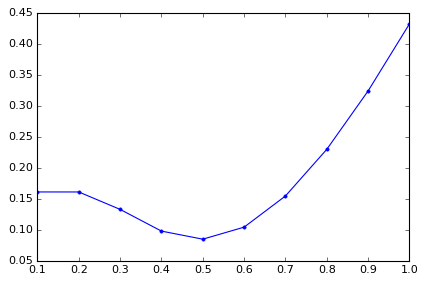

In [13]:
plt.plot(Lambda_list,error_L,'.-')

In [8]:
#So we decide to find the best lambda in [0.4,0.6]
Lambda_list_1=np.arange(4,6,0.1)*0.1
error_L_1=map(cost_function_lambda,Lambda_list_1)

Lambda is 0.4   500  is done date is  2008-12-29 00:00:00
2010-10-11 00:00:00
Lambda is 0.4   1000  is done date is  2010-12-28 00:00:00
Lambda is 0.4   1500  is done date is  2012-12-26 00:00:00
2014-07-08 00:00:00
Lambda is 0.4   2000  is done date is  2014-12-29 00:00:00
2015-08-10 00:00:00
Lambda is 0.4   2500  is done date is  2016-12-28 00:00:00
Lambda is  0.4 ;Function is  0.0975266474094
Lambda is 0.41   500  is done date is  2008-12-29 00:00:00
2010-10-11 00:00:00
Lambda is 0.41   1000  is done date is  2010-12-28 00:00:00
Lambda is 0.41   1500  is done date is  2012-12-26 00:00:00
Lambda is 0.41   2000  is done date is  2014-12-26 00:00:00
Lambda is 0.41   2500  is done date is  2016-12-23 00:00:00
Lambda is  0.41 ;Function is  0.0949061882058
Lambda is 0.42   500  is done date is  2008-12-29 00:00:00
2010-10-11 00:00:00
Lambda is 0.42   1000  is done date is  2010-12-28 00:00:00
Lambda is 0.42   1500  is done date is  2012-12-26 00:00:00
Lambda is 0.42   2000  is done date i

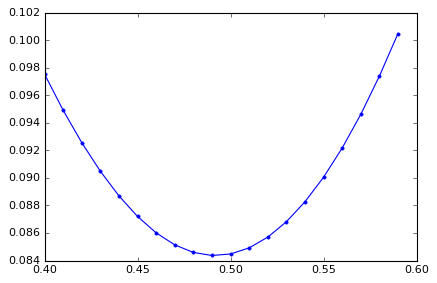

In [10]:
plt.plot(Lambda_list_1,error_L_1,".-")

In [22]:
#[0.48,0.50]
Lambda_list_2=np.arange(0.48,0.50,0.001)
error_L_2=map(cost_function_lambda,Lambda_list_2)

Lambda is 0.48   500  is done date is  2008-12-29 00:00:00
2010-10-11 00:00:00
Lambda is 0.48   1000  is done date is  2010-12-28 00:00:00
Lambda is 0.48   1500  is done date is  2012-12-26 00:00:00
Lambda is 0.48   2000  is done date is  2014-12-26 00:00:00
Lambda is 0.48   2500  is done date is  2016-12-23 00:00:00
Lambda is  0.48 ;Function is  0.0845894734938
Lambda is 0.481   500  is done date is  2008-12-29 00:00:00
2010-10-11 00:00:00
Lambda is 0.481   1000  is done date is  2010-12-28 00:00:00
Lambda is 0.481   1500  is done date is  2012-12-26 00:00:00
Lambda is 0.481   2000  is done date is  2014-12-26 00:00:00
Lambda is 0.481   2500  is done date is  2016-12-23 00:00:00
Lambda is  0.481 ;Function is  0.0845524745753
Lambda is 0.482   500  is done date is  2008-12-29 00:00:00
2010-10-11 00:00:00
Lambda is 0.482   1000  is done date is  2010-12-28 00:00:00
Lambda is 0.482   1500  is done date is  2012-12-26 00:00:00
Lambda is 0.482   2000  is done date is  2014-12-26 00:00:00
L

The best Lambda for the data is 0.492


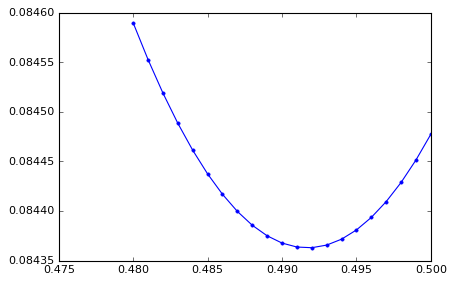

In [24]:
plt.plot(Lambda_list_2,error_L_2,".-")
print "The best Lambda for the data is",Lambda_list_2[np.argmin(error_L_2)]

In [25]:
#We use the minimize from optimize. We get the same result. It is much easier. 
#But the iteration sometimes repeat and I don't know the reason.
start_time = datetime.now()
res=minimize(cost_function_lambda,x0=0.5,options={'disp': True})
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Lambda is [ 0.5]   500  is done date is  2008-12-29 00:00:00
2010-10-11 00:00:00
Lambda is [ 0.5]   1000  is done date is  2010-12-28 00:00:00
Lambda is [ 0.5]   1500  is done date is  2012-12-26 00:00:00
Lambda is [ 0.5]   2000  is done date is  2014-12-26 00:00:00
Lambda is [ 0.5]   2500  is done date is  2016-12-23 00:00:00
Lambda is  [ 0.5] ;Function is  0.0844772801708
Lambda is [ 0.50000001]   500  is done date is  2008-12-29 00:00:00
2010-10-11 00:00:00
Lambda is [ 0.50000001]   1000  is done date is  2010-12-28 00:00:00
Lambda is [ 0.50000001]   1500  is done date is  2012-12-26 00:00:00
Lambda is [ 0.50000001]   2000  is done date is  2014-12-26 00:00:00
Lambda is [ 0.50000001]   2500  is done date is  2016-12-23 00:00:00
Lambda is  [ 0.50000001] ;Function is  0.0844772805826
Lambda is [ 0.5]   500  is done date is  2008-12-29 00:00:00
2010-10-11 00:00:00
Lambda is [ 0.5]   1000  is done date is  2010-12-28 00:00:00
Lambda is [ 0.5]   1500  is done date is  2012-12-26 00:00:00

### Question3

In [107]:
Lambda_opt=res.x
def calculate_beta(Lambda):
    beta=pd.DataFrame(0,columns=['beta0','beta1','beta2'],index=data.index)
    x0=[3,0,0]
    for date in data.index:
        try:
            tmp=error_beta(expire_time,data.loc[date],x0,Lambda)
            x0=tmp[0]
            beta.loc[date]=tmp[0]
        except:
            beta.loc[date]=np.nan
    return beta

beta=calculate_beta(Lambda_opt)
beta.head()

,beta0,beta1,beta2
Date,,,
2007-01-02,4.820898,0.231944,-0.655847
2007-01-03,4.816575,0.245765,-0.761783
2007-01-04,4.775764,0.268144,-0.833633
2007-01-05,4.787123,0.263141,-0.704771
2007-01-08,4.787896,0.309766,-0.731236


In [101]:
def my_pca(df,num):
    df=df
    cov=df.cov()
    xcv,vcv=np.linalg.eig(cov)
    pca_factor=df.dot(vcv[:,:num])
    return xcv,vcv[:,:num],pca_factor

xcv_dr,vcv_dr,pca_factor=my_pca(data,3)
pca_factor.head()

,0,1,2
Date,,,
2007-01-02,15.616114,3.538007,-0.783477
2007-01-03,15.572684,3.509722,-0.811767
2007-01-04,15.447520,3.450647,-0.832578
2007-01-05,15.542307,3.486045,-0.796735
2007-01-08,15.621408,3.453651,-0.811249


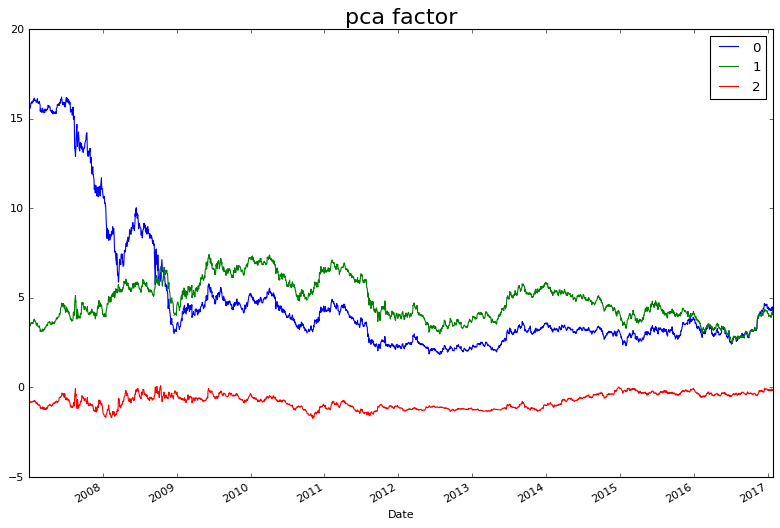

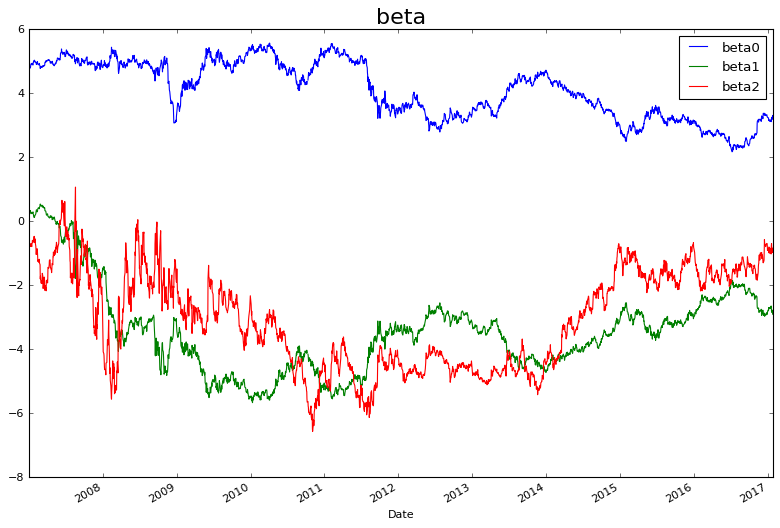

In [108]:
pca_factor.plot(figsize=(12,8))
plt.title("pca factor",fontsize=20)
beta.plot(figsize=(12,8))
plt.title("beta",fontsize=20)

In [110]:
pca_beta=pd.concat([pca_factor,beta],axis=1)
pca_beta.corr()

,0,1,2,beta0,beta1,beta2
0,1.000000,0.000052,0.001215,0.556274,0.626176,0.455404
1,0.000052,1.000000,0.000488,0.779796,-0.777844,-0.241422
2,0.001215,0.000488,1.000000,-0.286057,0.052719,0.856226
beta0,0.556274,0.779796,-0.286057,1.000000,-0.273309,-0.181733
beta1,0.626176,-0.777844,0.052719,-0.273309,1.000000,0.517385
beta2,0.455404,-0.241422,0.856226,-0.181733,0.517385,1.000000


* Conclusion: Actually, I don't find any valuable connection between pca factor and beta.